In [294]:
import numpy as np
from matplotlib import pyplot as plt
import math

In [295]:
class Espira:
    def __init__(self, i, N, k_i, m_i, l, L, g, t=0, x=0, y=0, v_x=0, v_y=0, resx=1000, resy=1000):
        self.i = i      # Índice da espira
        self.N = N      # Índice máximo
        self.k_i = k_i  # Constante da elástica da espira
        self.m_i = m_i  # Massa da espira
        self.l = l      # Comprimento da espira
        self.x = x      # Coordenada x
        self.y = y      # Coordenada y
        self.v_x = v_x  # Velocidade em x
        self.v_y = v_y  # Velocidade em y
        self.g = g      # gravidade
        self.L = L      # tamanho do vão
        self.t = 0      # tempo do sistema
        self.resx = resx
        self.resy = resy

    def __repr__(self):
        return (f"Espira(i={self.i}, N={self.N}, k_i={self.k_i}, m_i={self.m_i}, l={self.l}, "
                f"x={self.x}, y={self.y}, v_x={self.v_x}, v_y={self.v_y}")

    def derivadas_sistema_espira(self, t, espira_im1=None, espira_ip1=None, verbose=False):
        dxdt = self.dxdt()
        dydt = self.dydt()
        dv_xdt = self.dv_xdt(t, getattr(espira_im1, 'x', None), getattr(espira_ip1, 'x', None))
        dv_ydt = self.dv_ydt(t, getattr(espira_im1, 'y', None), getattr(espira_ip1, 'y', None))

        if verbose:
            print('------------')
            print(f"espira: {self.i}")
            print(f"x = {self.x} + h*{dxdt}")
            print(f"y = {self.y} + h*{dydt}")
            print(f"v_x = {self.v_x} + h*{dv_xdt}")
            print(f"v_y = {self.v_y} + h*{dv_ydt}")
            print('------------')

        return [dxdt, dydt, dv_xdt, dv_ydt]

    def dv_xdt(self, t, x_im1=None, x_ip1=None):
        # a_x = k_i/m_i * (x_(i+1) - 2*x_i)           p/ i = 0
        # a_x = k_i/m_i * (L - 2*x_i + x_(i-1))       p/ i = N-1
        # a_x = k_i/m_i * (x_(i+1) - 2*x_i + x_(i-1)) caso contrario
        if self.i == 0:
            x_im1 = 0
        elif self.i == self.N-1:
            x_ip1 = self.L

        v_hat = math.copysign(1, -self.v_x)
        return (self.k_i / self.m_i) * (x_ip1 - (2*self.x) + x_im1) + (self.resx*self.v_x**2)*v_hat

    def dxdt(self):
        return self.v_x

    def dv_ydt(self, t, y_im1=None, y_ip1=None):
        # a_y = -g + k_i/m_i * (y_(i+1) - 2*y_i)           p/ i = 0
        # a_y = -g + k_i/m_i * (2*y_i + y_(i-1))           p/ i = N-1
        # a_y = -g + k_i/m_i * (y_(i+1) - 2*y_i + y_(i-1)) caso contrario

        if self.i == 0:
            y_im1 = 0
        elif self.i == self.N-1:
            y_ip1 = 0


        v_hat = math.copysign(1, -self.v_y)
        return -self.g + (self.k_i / self.m_i) * (y_ip1 - (2*self.y) + y_im1) + (self.resy*self.v_y**2)*v_hat

    def dydt(self):
        return self.v_y

In [296]:
class Mola:
    def __init__(self, N, K, M, L, g, resx=1000, resy=1000):
        self.N = N                  # Número de espiras
        self.S = N+1                # Número de Molas
        self.K = K                  # Constante elástica da mola
        self.M = M                  # Massa da espira
        self.L = L                  # tamanho do vão
        self.l = self.L/self.S      # Comprimento da espira
        self.k_i = K*self.S         # constante elástica das espiras
        self.g = g                  # gravidade
        self.m = M/self.N           # massa de uma epsira
        self.espiras = []           # arrya de epsiras
        self.resx = resx
        self.resy = resy

        self.instanciar_espiras()

    def instanciar_espiras(self):
        for idx in range(0, self.N):
            self.espiras.append(
                Espira(
                    i=idx,
                    N=self.N,
                    k_i=self.k_i,
                    m_i=self.m,
                    l=self.l,
                    L=self.L,
                    g=self.g,
                    t=0,
                    x=self.l*(idx+1),
                    y=0,
                    v_x=0,
                    v_y=0,
                    resx=self.resx,
                    resy=self.resy
                )
            )

    def plotar_espiras(self, no_plot=False):
        x_coords = [espira.x for espira in self.espiras]
        y_coords = [espira.y for espira in self.espiras]

        plt.scatter(x_coords, y_coords)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Posições das Espiras')

        if no_plot:
            plt.clf()
        else:
            plt.show()


    def euler(self, t_0, t_final, step):
        it = int((t_final-t_0)/step)
        for t in np.linspace(t_0, t_final, it):
            # self.plotar_espiras()
            z_0 = np.array(self.valores_atuais())
            dzdt = step*np.array(self.derivadas_sistema_mola(t))
            z = z_0 + step*dzdt
            self.atualizar_valores(z)


    def valores_atuais(self):
        vars = []
        for espira in self.espiras:
            vars += [espira.x, espira.y, espira.v_x, espira.v_y]
        return vars

    def atualizar_valores(self, z):
        for espira in self.espiras:
            idx = espira.i*4
            espira.x = z[idx]
            espira.y = z[idx+1]
            espira.v_x = z[idx+2]
            espira.v_y = z[idx+3]

    def derivadas_sistema_mola(self, t):
        z_ = []
        idx = 0
        for espira_im1, espira, espira_ip1 in zip([None] + self.espiras[:-1], self.espiras, self.espiras[1:] + [None]):
            z_ += espira.derivadas_sistema_espira(t, espira_im1=espira_im1, espira_ip1=espira_ip1)
            idx += 1

        return z_

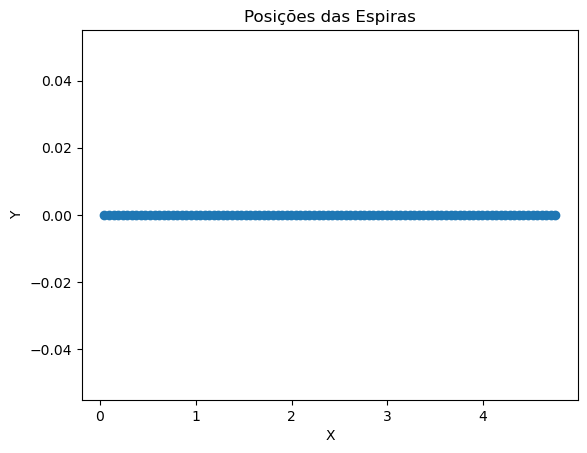

In [297]:
mola = Mola(N=100, K=0.656, M=0.251, L=L, g=9.8)
mola.plotar_espiras()

C:\Users\davi2\AppData\Local\Temp\ipykernel_17496\569172616.py:66: RuntimeWarning: overflow encountered in scalar power
  return -self.g + (self.k_i / self.m_i) * (y_ip1 - (2*self.y) + y_im1) + (self.resy*self.v_y**2)*v_hat


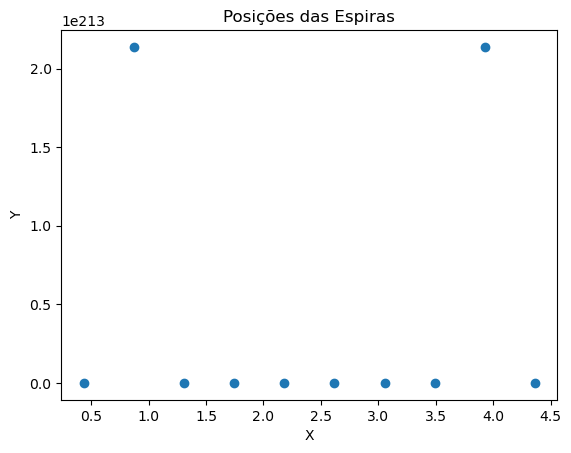

[Espira(i=0, N=10, k_i=11000, m_i=0.0251, l=0.43636363636363634, x=0.4363637465696874, y=-8.726947476969088e+183, v_x=0.00021876695819233587, v_y=inf,
 Espira(i=1, N=10, k_i=11000, m_i=0.0251, l=0.43636363636363634, x=0.8727272883616224, y=2.137448329353584e+213, v_x=-0.0004673388943824067, v_y=-inf,
 Espira(i=2, N=10, k_i=11000, m_i=0.0251, l=0.43636363636363634, x=1.3090903934751306, y=-2.8230344940179407e+142, v_x=0.0006893765437435992, v_y=3.187809501766052e+288,
 Espira(i=3, N=10, k_i=11000, m_i=0.0251, l=0.43636363636363634, x=1.7454558464805106, y=-6.719453957495621e+74, v_x=-0.0007740239661765584, v_y=1.8060424594761425e+153,
 Espira(i=4, N=10, k_i=11000, m_i=0.0251, l=0.43636363636363634, x=2.181816180904962, y=1.9290415806012045e+34, v_x=0.0006883940121015788, v_y=-1.4884805678753578e+72,
 Espira(i=5, N=10, k_i=11000, m_i=0.0251, l=0.43636363636363634, x=2.6181839569529357, y=1.929041580601175e+34, v_x=-0.0005540842102036394, v_y=-1.4884805678753113e+72,
 Espira(i=6, N=10, k_

In [308]:
azulejos=8
L = 0.6*azulejos
mola = Mola(N=10, K=0.656, M=0.251, L=L, g=9.8, resx=1000, resy=10)
mola.euler(t_0=0, t_final=1000, step=0.05)
mola.plotar_espiras()
mola.espiras

In [299]:
def passo_euler(t, mola, step):
    z_0 = np.array(mola.valores_atuais())
    dzdt = step*np.array(mola.derivadas_sistema_mola(t))
    z = z_0 + step*dzdt
    mola.atualizar_valores(z)

In [300]:
# import matplotlib.animation as animation
#
# nome_animacao = 'teste'
# segundos = 20
# frames = segundos*30
# step=0.05
#
# L = 0.6*8
# mola = Mola(N=10, K=0.656, M=0.251, L=L, g=9.8)
#
# fig, ax = plt.subplots()
# scat = ax.scatter([], [])
# ax.set_xlim(0, L)  # Adjust as needed based on expected range
# ax.set_ylim(-1, 0.2)  # Adjust as needed based on expected range
# plt.show()
#
# def init():
#     return scat,
#
# def animate(i):
#     print(i, end='\r')
#     data = np.array([[espira.x, espira.y] for espira in mola.espiras])
#     scat.set_offsets(data)
#     mola.plotar_espiras(no_plot=True)
#
#     passo_euler(i, mola, step)
#     return scat,
#
# anim = animation.FuncAnimation(
#     fig,
#     animate,
#     init_func=init,
#     frames=frames,
#     blit=True,
#     interval=30,
# )
#
# anim.save(f'{nome_animacao}.mp4', writer='ffmpeg')